# By David Soto


TP4 Computational Statistics
#**TP4 : Improve the Metropolis-Hastings algorithm**



# Exercice 1 : Adaptive Metropolis-Hastings within Gibbs sampler

# 1.A – Metropolis-Hastings within Gibbs sampler

**Question 1**

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd
import copy
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
def log_pi(x,y):
    return -(x**2/a**2)-y**2-1/4*((x**2/a**2)-y**2)**2

def acc_ratiopi1(x_i, x_star, y):
    ratio = log_pi(x_star,y)-log_pi(x_i,y)
    alpha1 = min(np.log(1), ratio)
    return alpha1

def acc_ratiopi2(y_i, y_star, x):
    ratio = log_pi(x, y_star)-log_pi(x, y_i)
    alpha2 = min(np.log(1), ratio)
    return alpha2

Pour l'implémentation de l'algorithme, l'idée est de faire un Metropolis-Hastings within Gibbs où l'on choisit aléatoirement l'axe que l'on modifie à chaque étape, comme suit :

In [3]:
def mh_within_Gibbs(n,x0,y0,sigma,p):
    chain = np.zeros((n,2))
    chain[0] = (x0,y0)

    # Pour les plot :
    acc_rate_x = []
    acc_rate_y = []
    accepted_x = 0 
    accepted_y = 0
    mean_acc_rate_x = []
    mean_acc_rate_y = []

    for i in range(1,n):
        u = np.random.rand()
        # On choisit aléatoirement P1 ou P2, càd on choisit de faire un saut aléatoirement soit sur x, soit sur y
        # Pour P1 :
        if u <= p : 
            x = np.random.normal(chain[i-1,0],sigma[0][0],size=1)
            alpha = acc_ratiopi1(chain[i-1,0], x, chain[i-1,1])

            acc_rate_x.append(np.exp(alpha))

            U = np.random.uniform(0,1)
            # Acceptation 
            if np.log(U) <= alpha:
                chain[i] = [x,chain[i-1,1]]
                accepted_x += 1
            else:
                chain[i] = chain[i-1]  
        # Pour P2 :
        else:
            y = np.random.normal(chain[i-1,1],sigma[1][1],size=1)
            alpha = acc_ratiopi2(chain[i-1,1], y, chain[i-1,1])

            acc_rate_y.append(np.exp(alpha))

            U = np.random.uniform(0,1)
            # Acceptation
            if np.log(U) <= alpha:
                chain[i] = [chain[i-1,0],y]
                acc_rate_y.append(U)
                accepted_y += 1
            else:
                chain[i]=chain[i-1]  
                acc_rate_y.append(np.exp(alpha))
        mean_acc_rate_x.append(accepted_x/i)
        mean_acc_rate_y.append(accepted_y/i)
    return chain, acc_rate_x, acc_rate_y, mean_acc_rate_x, mean_acc_rate_y

**Question 2**

On exécute l'algorithme avec a = 10  &  $(\sigma_1, \sigma_2) = (3,3)$

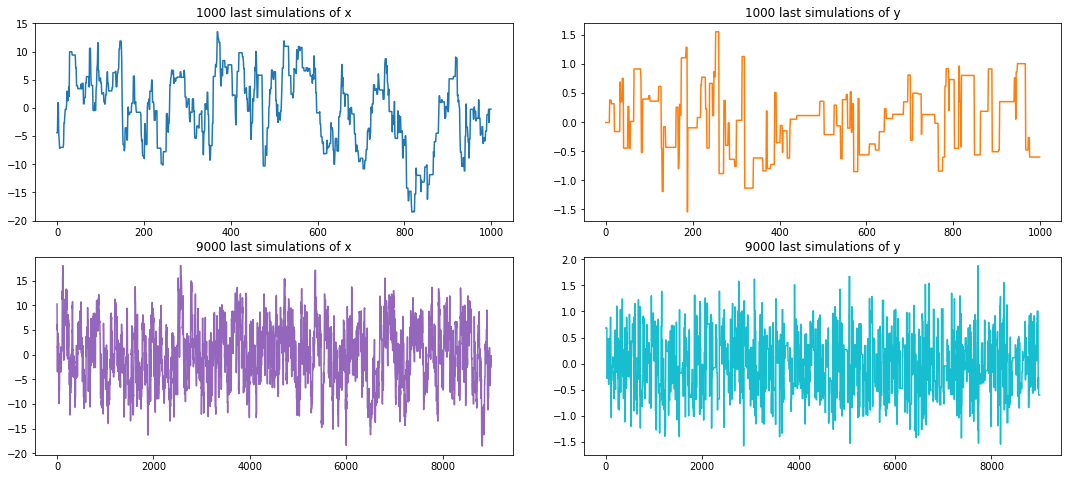

In [4]:
##### Parameters @@@@@
a=10
sigma = [[3,0],[0,3]]
x0 = 0
y0 = 0
p = 0.5

# We run the algorithm
chain = mh_within_Gibbs(10000,x0,y0,sigma,p)

# We plot the results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
plt.subplots_adjust(left=0.125,
                    bottom=0.5, 
                    right=2.5, 
                    top=2, 
                    wspace=0.15, 
                    hspace=0.18)

ax1.plot(chain[0][9000:,0])
ax1.set_title("1000 last simulations of x")

ax2.plot(chain[0][9000:,1], 'tab:orange')
ax2.set_title("1000 last simulations of y")

ax3.plot(chain[0][1000:,0], 'tab:purple')
ax3.set_title("9000 last simulations of x")

ax4.plot(chain[0][1000:,1], 'tab:cyan')
ax4.set_title("9000 last simulations of y")

plt.show()

En observant les graphes de x et de y, on peut remarquer la présence de corrélation (qui est un peu plus visible pour x). On le voit surtout sur le graphe des 1000 dernières simulations. Afin de vérifier cela, nous allons utiliser la fonction ACF, comme suit :

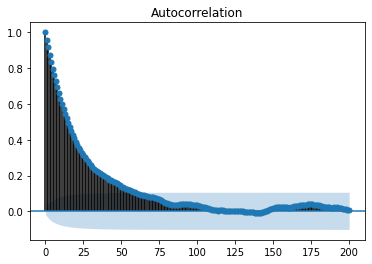

In [5]:
# ACF pour x
plot_acf(chain[0][2000:,0], lags=200);

On peut constater avec ce graphe qu'il y a une forte auto-corrélation dans les premiers lags. 

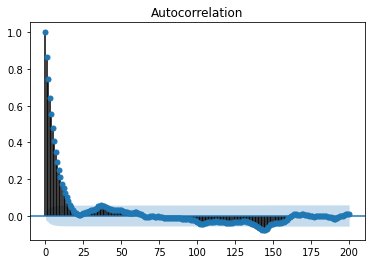

In [6]:
# ACF pour y
plot_acf(chain[0][2000:,1], lags=200);

Pour les y, on peut constater une forte auto-corrélation positive dans les premiers lags (qui est cependant moins forte que celles des x). 

Nous allons afficher le graphe des "mean acceptance rate" de x et de y, comme celles de l'énoncé.

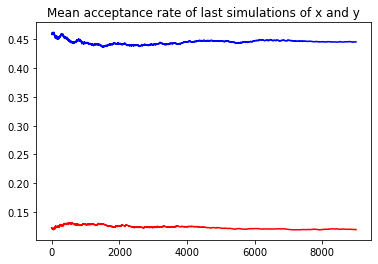

In [7]:
plt.plot(chain[3][1000:], c='blue')
plt.title("Mean acceptance rate of last simulations of x and y")
plt.plot(chain[4][1000:], c='red')
plt.show()

On constate que les mean acceptance rate sont très loin du 0.24 prôné dans l'énoncé.

Tous ces détails nous laissent à penser les performances de l'algorithme peuvent être améliorés.

**Question 3**

Un moyen d'améliorer la performance de notre algorithme est de réduire l'auto-corrélation des données simulées mais aussi de faire en sorte que les mean acceptance rate se rapproche de la valeur 0.24.

# 1.B – Adaptative Metropolis-Hastings within Gibbs sampler

**Question 1**

On implémente l'adaptative MHwG sampler en utilisant la fonction $\pi$ de la partie A comme densité. 

In [8]:
def adaptive_mh_within_Gibbs(n,x0,y0,sigma):
    # We set the variables l1 & l2 which are the logarithm of the standard deviations
    l1 = np.log(sigma[0][0])
    l2 = np.log(sigma[1][1])

    chain = np.zeros((n,2))
    chain[0] = (x0,y0)
    acc_rate_x = []
    acc_rate_y= []
    alpha1 = 0
    alpha2= 0
    accepted_x, accepted_y=0,0
    batch_mean_acc_x, batch_mean_acc_y=[],[]
    accepted_x2, accepted_y2=0,0
    mean_acc_rate_x, mean_acc_rate_y=[],[]

    for j in range(int(n/50)):
        if j > 0:
            if accepted_x2/i > 0.24:
                l1 += min(0.01, 1/np.sqrt(j))
            else:
                l1 -= min(0.01, 1/np.sqrt(j))
            if accepted_y2/i > 0.24:
                l2+=min(0.01, 1/np.sqrt(j))
            else:
                l2-=min(0.01, 1/np.sqrt(j))  
        batch_mean_acc_x.append(accepted_x/50)
        batch_mean_acc_y.append(accepted_y/50)
        accepted_x = 0
        accepted_y = 0
        for i in range(50*j,50*(j+1)):
            u = np.random.rand()
            if u <= 0.5 :
                x = np.random.normal(chain[i-1,0],np.exp(l1),size=1)
                alpha1 = acc_ratiopi1(chain[i-1,0], x, chain[i-1,1])
                acc_rate_x.append(alpha1)
                U = np.random.rand()
                if np.log(U) <= alpha1:
                    accepted_x += 1
                    accepted_x2 += 1
                    chain[i] = [x,chain[i-1,1]]
                else:
                    chain[i] = chain[i-1]      
            else:
                y = np.random.normal(chain[i-1,1],np.exp(l2),size=1)
                alpha2 = acc_ratiopi2(chain[i-1,1], y, chain[i-1,1])
                acc_rate_y.append(alpha2)
                U = np.random.rand()
                if np.log(U) <= alpha2:
                    accepted_y += 1          
                    accepted_y2 += 1                    
                    chain[i] = [chain[i-1,0],y]
                else:
                    chain[i] = chain[i-1]   
            if i > 0:
                mean_acc_rate_x.append(accepted_x2/i)
                mean_acc_rate_y.append(accepted_y2/i)
    return chain, acc_rate_x, acc_rate_y, mean_acc_rate_x, mean_acc_rate_y, batch_mean_acc_x, batch_mean_acc_y

On teste maintenant l'algorithme :

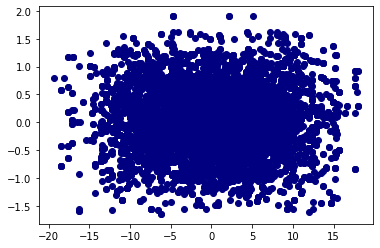

In [18]:
chain = adaptive_mh_within_Gibbs(10000,0,0,sigma=[[8,0],[0,2]])
plt.scatter(chain[0][1000:,0], chain[0][1000:,1], c='navy')
plt.show()

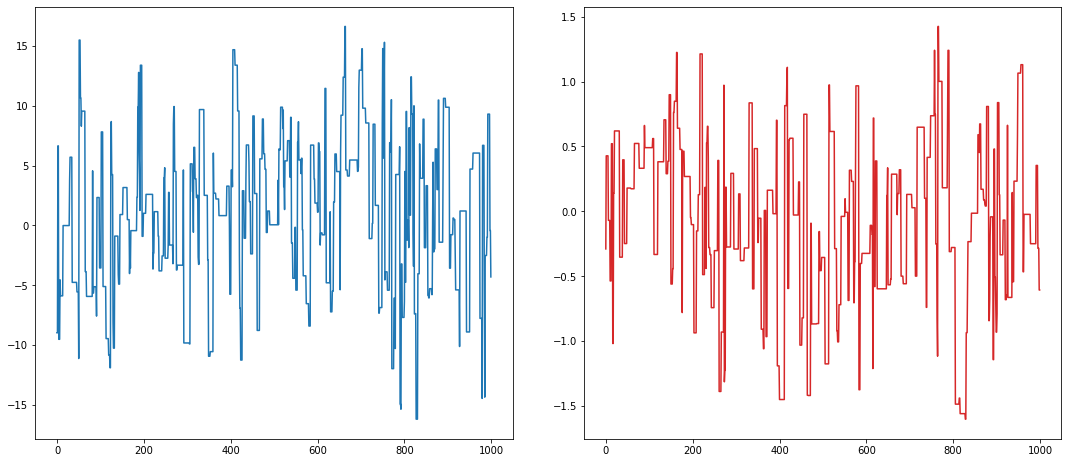

In [19]:
# We plot the results
fig, (ax1, ax2) = plt.subplots(1,2)
plt.subplots_adjust(left=0.125,
                    bottom=0.5, 
                    right=2.5, 
                    top=2, 
                    wspace=0.15, 
                    hspace=0.18)

ax1.plot(chain[0][9000:,0], 'tab:blue')

ax2.plot(chain[0][9000:,1], 'tab:red')

plt.show()

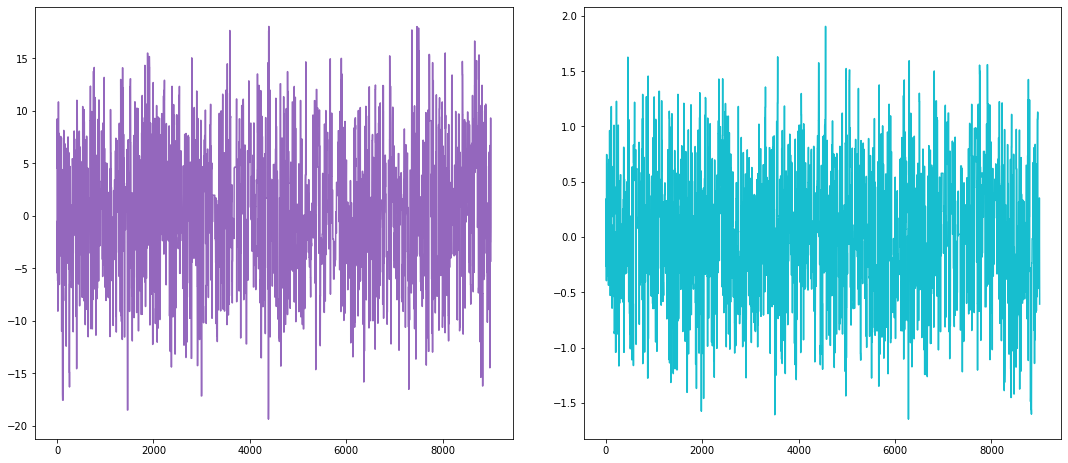

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2)
plt.subplots_adjust(left=0.125,
                    bottom=0.5, 
                    right=2.5, 
                    top=2, 
                    wspace=0.15, 
                    hspace=0.18)

ax1.plot(chain[0][1000:,0], 'tab:purple')

ax2.plot(chain[0][1000:,1], 'tab:cyan')

plt.show()

En observant les graphes, on remarque qu'il y a une diminution de la corrélation entre les itérations consécutives. Regardons les fonctions ACF pour s'en assurer :

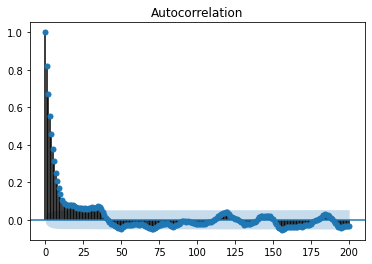

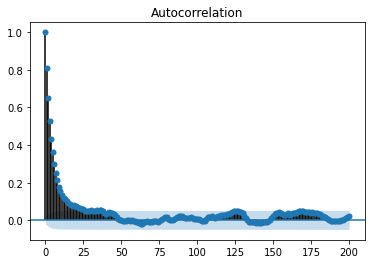

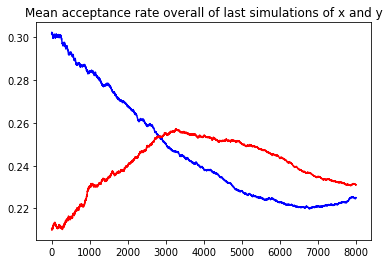

In [21]:
# ACF x
plot_acf(chain[0][2000:,0], lags=200);
plt.show()
# ACF y
plot_acf(chain[0][2000:,1], lags=200);
plt.show()
# Plot mean acceptance rate overall
plt.plot(chain[3][2000:], c='blue')
plt.title("Mean acceptance rate overall of last simulations of x and y")
plt.plot(chain[4][2000:], c='red')
plt.show()

On constate que les auto-corrélations ont diminuées (surtout pour x). Par ailleurs, on peut voir que le taux d'acception converge vers 0.24 pour x et pour y, ce qui est bon signe.

**Question 2**

Nous allons essayer notre algorithme sur une densité cible plus compliquées : la densité "banana-shaped".

In [22]:
# On définie la densité cible log_f
def log_f(x):
    return(-(x[0]**2)/200.-(0.5)*(x[1]+B*x[0]**2-100*B)**2-(0.5)*(np.sum(x[2:]**2)))


def acc_ratiof(x_i, x_star):
    ratio=log_f(x_star)-log_f(x_i)
    return min(np.log(1), ratio)

In [23]:
def adaptive_mh_within_Gibbs2(n,x0,sigma):
    l = np.log(sigma)
    chain = np.zeros((n,d))
    chain[0] = x0
    alpha = np.zeros((d))
    for j in range(int(n/50)):
        if j > 0:
            for r in range(d):
                if np.exp(alpha[r])>0.24:
                    l[r] += min(0.01, 1/np.sqrt(j))
                else:
                    l[r] -= min(0.01, 1/np.sqrt(j))
        for i in range(50*j,50*(j+1)):
            ent = np.random.randint(d)
            x = copy.deepcopy(chain[i-1])
            x[ent] = np.random.normal(chain[i-1,ent],np.exp(l[ent]),size=1)            
            alpha[ent] = acc_ratiof(chain[i-1], x)
            unif = np.random.uniform(0,1)
            if np.log(unif) <= alpha[ent]:
                chain[i] = x
            else:
                chain[i] = chain[i-1]      
    return(chain)

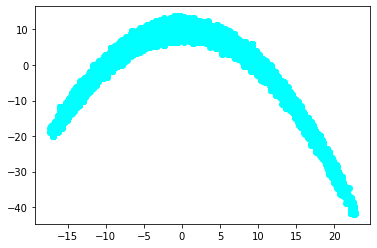

In [24]:
##### Parameters @@@@@
B=0.1
d=2
sigma=[1,1]
n=100000
x0=[0,0]
sigma=np.ones((d))

# We run our algorithm 
results=adaptive_mh_within_Gibbs2(n,x0,sigma)

# We plot the results
plt.scatter(results[2000:,0],results[2000:,1], c='cyan')
plt.show()

# Exercise 2: Sampling from multimodal distributions


# 2.A – A toy example

**Question 1**

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd
import copy
from statsmodels.graphics.tsaplots import plot_acf

In [27]:
def gaussian_mix_pdf(x,mu,sigma):
    f = 0
    d = len(mu)
    for i in range(d):
        f += (1/d)/(2*np.pi*sigma[i]**2) * np.exp(-(x-mu[i,:]).T.dot(x-mu[i,:])/(2*sigma[i]**2))
    return f   

def acc_rate(x_star, x_old, mu, sigm):
    return(min(1,gaussian_mix_pdf(x_star, mu,sigm) / gaussian_mix_pdf(x_old, mu, sigm)))

Algorithme Hastings-Metropolis :

In [28]:
def gm_hm(N,x0, sigma=[[1,0],[0,1]]):
    sim = np.zeros((N+1,2))
    sim[0] = x0
    val = []
    for i in range(N):
        x_star = np.random.multivariate_normal(sim[i], sigma)
        alpha = acc_rate(x_star, sim[i], mu, np.full(len(mu),0.1))
        if np.random.rand() < alpha:
            results = x_star,alpha
        else:
            results = sim[i],alpha
        sim[i+1] = results[0]
        val.append(results[1])
    return sim,val

**Question 2**

On commence par implémenter l'algorithme adaptative Hastings-Metropolis.

In [29]:
def gm_adaptive_hm(N,x0, sigma=[[1,0],[0,1]]):
    l=np.log(np.diagonal(sigma))
    simulations = np.zeros((N+1,2))
    simulations[0]=x0
    val=[]
    alpha=0
    accepted=0
    for j in range(int(N/50)):
        if j > 0:
            if accepted/50>0.24:
                    l+=min(0.01, 1/np.sqrt(j))
            else:
                    l-=min(0.01, 1/np.sqrt(j))
        accepted=0
        for i in range(50*j,50*(j+1)):
            for a in range(len(sigma)):
                sigma[a][a]=np.exp(l[a])
            x_star = np.random.multivariate_normal(simulations[i], sigma)
            alpha = acc_rate(x_star, simulations[i], mu, np.full(len(mu),0.1))
            if np.random.rand()<alpha:
                results = x_star,alpha
                accepted+=1
            else:
                results = simulations[i],alpha
            simulations[i+1] = results[0]
            val.append(results[1])
    return simulations,val

On définie les moyennes $\mu_i$.

In [31]:
mu = np.array([[2.18,5.76],[8.67,9.59],
    [4.24,8.48],[8.41,1.68],
    [3.93,8.82],[3.25,3.47],
    [1.7,0.5],[4.59,5.6],
    [6.91,5.81],[6.87,5.40],
    [5.41,2.65],[2.7,7.88],
    [4.98,3.7],[1.14,2.39],
    [8.33,9.5], [4.93,1.5],
    [1.83,0.09],[2.26, 0.31],
    [5.54,6.86],[1.69,8.11]])

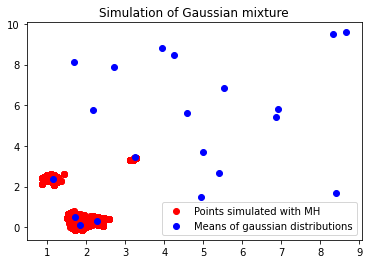

In [36]:
x0=(0, 0)

# Classique Metropolis Hastings
points = gm_hm(10000,x0,sigma=[[1,0],[0,1]])
fig = plt.figure()
plt.title("Simulation of Gaussian mixture")
plt.scatter(points[0][5000:,0],points[0][5000:,1], label='Points simulated with MH', c = 'red')
plt.scatter(mu[:,0],mu[:,1], label='Means of gaussian distributions', c='blue')
plt.legend()
plt.show()

On voit bien que l'algorithme Hastings Metropolis ne parvient pas à échantilloner correctement à partir de $\pi$. Regardons les autocorrélation de la chaîne.

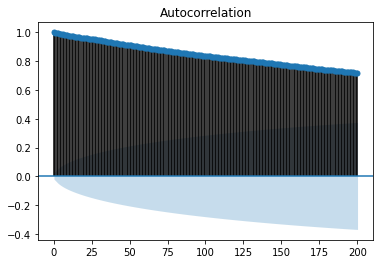

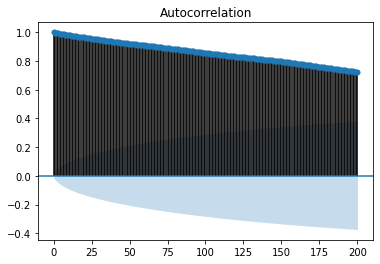

In [37]:
# ACF x1
plot_acf(points[0][2000:,0], lags=200);
plt.show()
# ACF x2
plot_acf(points[0][2000:,1], lags=200);
plt.show()

On peut voir que les autocorrélations de la chaîne sont très mauvaises ici ! Ce qui confirme le fait que l'algorithme ne parvient pas à échantillonner correctement à partir de $\pi$.

Regardons maintenant pour l'algorithme adaptative HM.

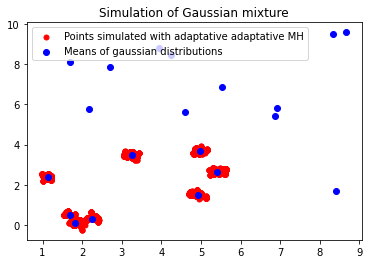

In [39]:
x0=(0, 0)
# Adaptative Hastings Metropolis
points = gm_adaptive_hm(5000,x0,sigma=[[1,0],[0,1]])
fig = plt.figure()
plt.title("Simulation of Gaussian mixture")
plt.scatter(points[0][1000:,0],points[0][1000:,1],s=25,label='Points simulated with adaptative adaptative MH', c = 'red')
plt.scatter(mu[:,0],mu[:,1],label='Means of gaussian distributions', c='blue')
plt.legend()
plt.show()

De même, on voit que l'algorithme adaptative Metropolis Hastings ne parvient pas à bien échantilloner à partir de $\pi$. Regardons les autocorrélations.

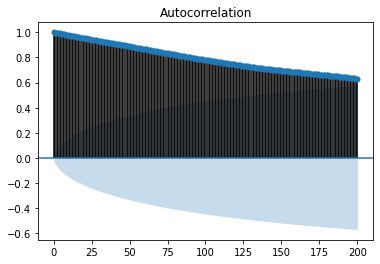

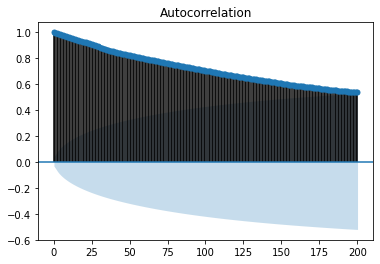

In [40]:
# ACF x1
plot_acf(points[0][2000:,0], lags=200);
plt.show()
# ACF x2
plot_acf(points[0][2000:,1], lags=200);
plt.show()

De même, les autocorrélations de la chaîne sont mauvaises ici ! Ce qui confirme également le fait que l'algorithme adaptative MH ne parvient pas à échantillonner correctement à partir de $\pi$.

# 2.B – Parallel Tempering

**Question 1**

In [41]:
def parallel_tempering_pre(x_old,target,t,sigma=1):   
    x_new = np.random.normal(x_old, sigma)
    alpha = min(0,np.log(pi(x_new))*(1/(1*t)) - np.log(pi(x_old))*(1/(1*t)))
    if (np.log(np.random.rand())<alpha):
        return x_new, alpha
    else:
        return x_old, alpha

def consec_choice(K):
        p=np.random.randint(K)
        if p == K-1:
            q= K-2
        elif p == 0:
            q=1
        else:
            u=np.random.uniform()
            if u < 1/2:
                q = p-1
            else:
                q=p+1
        return(p,q)
    

def acc_rate(x_star, x_old, mu, sigma, ind):
    aux=gaussian_mix_pdf((x_old),mu,sigma)**(1/T[ind[1]])*gaussian_mix_pdf((x_star),mu,sigma)**(1./(1.*T[ind[0]]))
    return(min(1,aux/(gaussian_mix_pdf((x_star),mu,sigma))**(1./(1.*T[ind[1]]))*gaussian_mix_pdf((x_old),mu,sigma)**(1./(1.*T[ind[0]]))))
    
def parallel_tempering(T,pi):
    Y = np.zeros((K,2,N+1))
    for i in range(N):
        for t in range(K):
            Y[t,:,i+1] = parallel_tempering_pre(Y[t,:,i],pi,T[t],sigma=(1/4)*np.sqrt(T[t]))[0]
        # choose consecutive indexes
        ind = consec_choice(K)
        # Compute the swap acceptance probability
        alpha = acc_rate(Y[ind[1],:,i+1], Y[ind[0],:,i+1], mu, sigma, ind)
        if (np.random.rand() < alpha):
            aux = Y[ind[0],:,i+1]
            Y[ind[0],:,i+1] = Y[ind[1],:,i+1]
            Y[ind[1],:,i+1] = aux
    return Y

**Question 2**

In [49]:
##### Parameters @@@@@
N=40000
K=5 
T= 60, 21.6, 7.7, 2.8, 1 # Temperature ladder

In [50]:
T = np.array([60,21.6,7.7,2.8,1])
d = len(mu)
sigma = 0.1
sigma = np.full(d,sigma)
pi = lambda x : gaussian_mix_pdf(x,mu,sigma) # distribution pi of part A 
Y = parallel_tempering(T,pi)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


[]

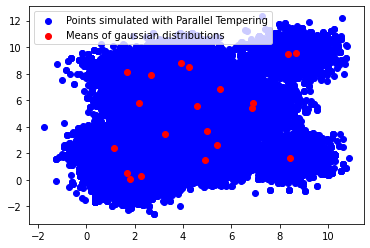

In [51]:
# T0
fig = plt.figure()
plt.scatter(Y[0,0,1000:],Y[0,1,1000:],label='Points simulated with Parallel Tempering', c='blue')
plt.scatter(mu[:,0],mu[:,1],label='Means of gaussian distributions', c='red')
plt.legend()
plt.plot()

[]

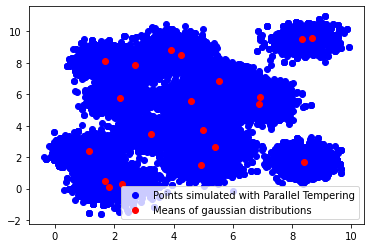

In [52]:
#T1
fig = plt.figure()
plt.scatter(Y[1,0,1000:],Y[1,1,1000:],label='Points simulated with Parallel Tempering', c='blue')
plt.scatter(mu[:,0],mu[:,1],label='Means of gaussian distributions', c='red')
plt.legend()
plt.plot()

[]

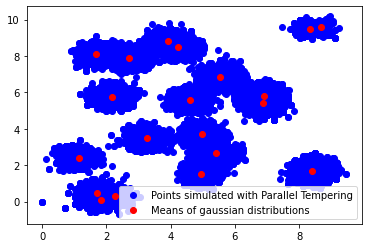

In [53]:
#T2
fig = plt.figure()
plt.scatter(Y[2,0,:],Y[2,1,:],label='Points simulated with Parallel Tempering', c="blue")
plt.scatter(mu[:,0],mu[:,1],label='Means of gaussian distributions', c="red")
plt.legend()
plt.plot()

[]

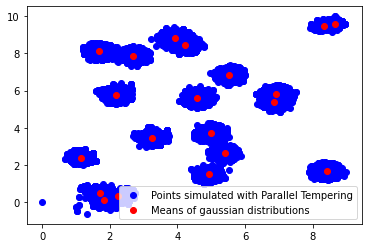

In [54]:
#T3
fig = plt.figure()
plt.scatter(Y[3,0,:],Y[3,1,:],label='Points simulated with Parallel Tempering', c='blue')
plt.scatter(mu[:,0],mu[:,1],label='Means of gaussian distributions', c="red")
plt.legend()
plt.plot()


[]

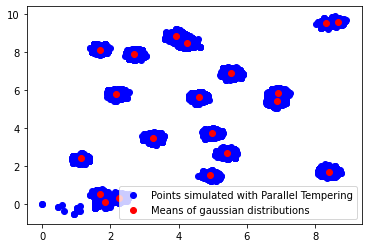

In [55]:
#T4
fig = plt.figure()
plt.scatter(Y[4,0,:],Y[4,1,:],label='Points simulated with Parallel Tempering', c="blue")
plt.scatter(mu[:,0],mu[:,1],label='Means of gaussian distributions', c='red')
plt.legend()
plt.plot()

# Exercise 3: Bayesian analysis of a one-way random effects model

**Question 2**

In [56]:
import numpy as np
import matplotlib.pyplot as plt

In [57]:
 def invgamma(a, b):
    return 1 / np.random.gamma(a, 1/b)

Implementation of the a Gibbs sampler which updates in turn $(\sigma^2, \tau^2, \mu, X)$ one at a time.

In [58]:
def gibbs(y, alpha, beta, gamma, n): 

    # Sample n quadruplets (sigma2, tau2, mu, X) using Gibbs sampling on blocks:
    # sigma2 then tau2 then mu then X

    N = len(y)
    k = np.array([len(yi) for yi in y])
    K = k.sum()
    sigma2 = invgamma(alpha, beta)
    tau2 = invgamma(gamma, beta)
    sy = np.array([yi.sum() for yi in y])
    mu = (sy / k).mean()
    def getX():
        s2 = 1 / (1/sigma2 + k/tau2)
        return np.random.normal(s2*(mu/sigma2 + sy/tau2), s2 ** 0.5, N)
    X = getX()
    samples = []
    # We update (sigma2,tau2,mu,X) one at a time, as follows :
    for _ in range(n):
        sigma2 = invgamma(alpha + N/2, beta + 0.5*((X - mu)**2).sum())
        tau2 = invgamma(gamma + K/2, beta + 0.5*sum(((X[i] - y[i])**2).sum() for i in range(N)))
        mu = np.random.normal(X.mean(), (sigma2/N) ** 0.5)
        X = getX()
        samples.append((sigma2, tau2, mu, X))
    return [np.array([s[i] for s in samples]) for i in range(4)]

**Question 3**

Implementation of a Block-Gibbs sampler which updates $\sigma^2$, then $\tau^2$, and then the block $(X,\mu)$.

In [59]:
def gibbs_block(y, alpha, beta, gamma, n):
    
    #Sample n quadruplets (sigma2, tau2, mu, X) using Gibbs sampling on blocks:
    #sigma2 then tau2 then (X, mu)

    N = len(y)
    k = np.array([len(yi) for yi in y])
    K = k.sum()
    sigma2 = invgamma(alpha, beta)
    tau2 = invgamma(gamma, beta)
    my = np.array([yi.mean() for yi in y])
    def getXmu():
        X = np.random.normal(my, tau2/k)
        mu = np.random.normal(X.mean(), (sigma2/N) ** 0.5)
        return X, mu
    X, mu = getXmu()
    samples = []
    # We update sigma2, then tau2 and then (X,mu) as follows :
    for _ in range(n):
        sigma2 = invgamma(alpha + N/2, beta + 0.5*((X - mu)**2).sum())
        tau2 = invgamma(gamma + K/2, beta + 0.5*sum(((X[i] - y[i])**2).sum() for i in range(N)))
        X, mu = getXmu()
        samples.append((sigma2, tau2, mu, X))
    return [np.array([s[i] for s in samples]) for i in range(4)]

**Question 4**

En théorie, le Block-Gibbs permet d'avoir une convergence plus rapide comparé au Gibbs classique. L'explication est que plus on fait de gros blocs, plus on simule à chaque étape un phénomène qui décrit une grande portion de l'information de la distribution. Dans la pratique, cependant, il n'y a pas forcément une différence énorme. 

**Question 5**

In [61]:
##### PARAMETERS @@@@@
alpha = 3
beta = 5
gamma = 100
N = 30
# k_i is chosen uniformly in {kmin, ..., kmax-1}
kmin, kmax = 3, 10

#####################
assert alpha > 2 and gamma > 1
assert kmin < kmax

################# Dataset Generation #################
# We generate a synthetic dataset following the model : 
sigma = invgamma(alpha, beta) ** 0.5
tau = invgamma(gamma, beta) ** 0.5

mu = np.random.normal(0, beta**2 / (alpha - 1)**2 / (alpha - 2))
k = np.random.randint(kmin, kmax, N)
x = np.random.normal(mu, sigma, N)
y = [x[i] + np.random.normal(0, tau, k[i]) for i in range(N)]

print("E[sigma^2]:", beta/(alpha-1))
print( "Var[sigma^2]:", beta**2 / (alpha - 1)**2 / (alpha - 2))
print("E[tau^2]:", beta/(gamma-1))
print("Var[tau^2]:", beta**2 / (gamma - 1)**2 / (gamma - 2))
print(" ")
print("These are the real parameters :")
print("REAL sigma^2:", sigma**2, "\nREAL tau^2:", tau**2, "\nREAL mu:", mu)

E[sigma^2]: 2.5
Var[sigma^2]: 6.25
E[tau^2]: 0.050505050505050504
Var[tau^2]: 2.6028164556303082e-05
 
These are the real parameters :
REAL sigma^2: 0.9724520357772901 
REAL tau^2: 0.049905264950219345 
REAL mu: -13.667055132705224


Now we test our code on the synthetic dataset Y.

In [62]:
##### PARAMETER @@@@@
n = 500

**Results with the first Gibbs Sampler (from question 2)**

In [63]:
ss, ts, ms, xs = gibbs(y, alpha, beta, gamma, n)

print("sigma^2:", ss.mean(), "\t\tVar =", ss.var())
print("tau^2:", ts.mean(), "\t\tVar =", ts.var())
print("mu:", ms.mean(), "\t\tVar =", ms.var())

sigma^2: 1.1488873424920734 		Var = 0.09182952932409973
tau^2: 0.0453705442190185 		Var = 1.1115953868901488e-05
mu: -13.663720972575339 		Var = 0.03731437945681621


**Results with the second Gibbs Sampler (Block-Gibbs sampler from question 3)**

In [64]:
ss, ts, ms, xs = gibbs_block(y, alpha, beta, gamma, n)

print("sigma^2:", ss.mean(), "\t\tVar =", ss.var())
print("tau^2:", ts.mean(), "\t\tVar =", ts.var())
print("mu:", ms.mean(), "\t\tVar =", ms.var())

sigma^2: 1.1302698887267135 		Var = 0.06854372518954162
tau^2: 0.0419599559707415 		Var = 8.718860144719612e-06
mu: -13.651399152079819 		Var = 0.03361701718429943
